## Bayesian neural network on simulated data

In [433]:
import torch
import torch.nn as nn
import torch.distributions as dist

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

from torch.optim import Adam

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import time

In [434]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Simulate data

In [564]:
# Let's use latent_dim = 1 and x_dim = 1 so that we may plot the data.
latent_dim = 1
hidden_dim = 10
x_dim = 1
use_bias = True

In [715]:
torch.manual_seed(1954)
nObs = 100

z = torch.randn((nObs, 1)) * 5
x = 0.5 * z + 1 + torch.randn((nObs, 1))  # torch.sin(z) * z + z + torch.randn((nObs, 1))

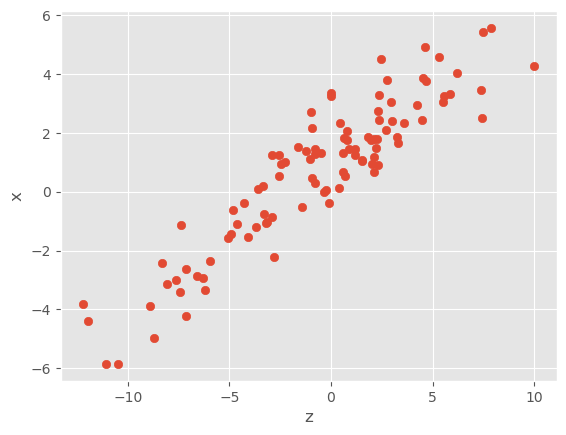

In [716]:
plt.scatter(z.detach().numpy(), x.detach().numpy())
plt.xlabel("z")
plt.ylabel("x")
plt.show()

## Build model

In [700]:
def likelihood_NN(theta, z, latent_dim, hidden_dim, x_dim):
    index_layer1 = latent_dim * hidden_dim
    index_layer2 = index_layer1 + hidden_dim**2
    index_out = index_layer2 + hidden_dim * 2 * x_dim
    index_bias1 = index_out + hidden_dim
    index_bias2 = index_bias1 + hidden_dim

    # weights
    W1 = theta[:index_layer1].reshape((hidden_dim, latent_dim))    
    W2 = theta[index_layer1:index_layer2].reshape((hidden_dim, hidden_dim))   
    W3 = theta[index_layer2:index_out].reshape((2 * x_dim, hidden_dim))

    # bias
    b1 = theta[index_out:index_bias1].reshape((hidden_dim))
    b2 = theta[index_bias1:index_bias2].reshape((hidden_dim))
    b3 = theta[index_bias2:].reshape((2 * x_dim))

    LeakyRelu = nn.LeakyReLU(0.2)
    h = LeakyRelu(torch.matmul(z, torch.t(W1)) + b1)
    h = LeakyRelu(torch.matmul(h, torch.t(W2)) + b2)
    out = torch.matmul(h, torch.t(W3)) + b3

    # print("\ttheta:", torch.t(theta))

    # print("\tW1:", W1)
    # print("\tW1:", W2)
    # print("\tW1:", W3)

    # print("\tb1:", torch.t(b1))
    # print("\tb2:", torch.t(b2))
    # print("\tb3:", torch.t(b3))


    return out


In [663]:
# class likelihood_NN(nn.Module):
#     def __init__(self, latent_dim, hidden_dim, x_dim, use_bias=True):
#         super(likelihood_NN, self).__init__()

#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.x_dim = x_dim

#         self.FC_hidden = nn.Linear(latent_dim, hidden_dim, bias = use_bias)
#         self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim, bias = use_bias)
#         self.FC_out = nn.Linear(hidden_dim, 2 * x_dim, bias = use_bias)

#         self.LeakyRelu = nn.LeakyReLU(0.2)

#     def forward(self, z, theta):
#         self.set_weights(self, theta)
#         h = self.LeakyRelu(self.FC_hidden(z))
#         h = self.LeakyRelu(self.FC_hidden2(h))
#         out = self.FC_out(h)

#         return out
    
#     def set_weights(self, theta):
#         index_layer1 = self.latent_dim * self.hidden_dim
#         self.FC_hidden.weight.data =\
#             theta[:index_layer1].reshape((self.hidden_dim, self.latent_dim)).clone()
#             # nn.Parameter(theta[:index_layer1].reshape((self.hidden_dim, self.latent_dim)))
#         self.FC_hidden.requires_grad_(True)

#         index_layer2 = index_layer1 + self.hidden_dim**2
#         self.FC_hidden2.weight =\
#             nn.Parameter(theta[index_layer1:index_layer2].reshape((self.hidden_dim, self.hidden_dim)))
#         self.FC_hidden2.requires_grad_(True)
    
#         index_mu = index_layer2 + self.hidden_dim * 2 * self.x_dim
#         self.FC_out.weight =\
#             nn.Parameter(theta[index_layer2:index_mu].reshape((2 * self.x_dim, self.hidden_dim)))
#         self.FC_out.requires_grad_(True)
    
#         # Set biases
#         index_bias1 = index_mu + self.hidden_dim
#         self.FC_hidden.bias = nn.Parameter(theta[index_mu:index_bias1].reshape((self.hidden_dim)))

#         index_bias2 = index_bias1 + self.hidden_dim
#         self.FC_hidden.bias = nn.Parameter(theta[index_bias1:index_bias2].reshape((self.hidden_dim)))

#         self.FC_out.bias = nn.Parameter(theta[index_bias2:].reshape((2 * self.x_dim)))       



In [664]:
class Encoder(nn.Module):
     
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.n = input_dim
        self.h = hidden_dim
        self.p = latent_dim

        self.FC_input = nn.Linear(self.n, self.h, bias = use_bias)
        self.FC_input2 = nn.Linear(self.h, self.h, bias = use_bias)
        self.FC_mean = nn.Linear(self.h, self.p, bias = use_bias)
        self.FC_sd_log = nn.Linear(self.h, self.p, bias = use_bias)

        self.LeakyRelu = nn.LeakyReLU(0.2)

        self.training = False  # CHECK -- what does this line do?

    def forward(self, x):
        h_ = self.LeakyRelu(self.FC_input(x))
        h_ = self.LeakyRelu(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        sd_log = self.FC_sd_log(h_)

        return mean, sd_log
    
    # def set_weights(self, theta):
    #     # Set weights
    #     index_layer1 = self.n * self.h
    #     self.FC_input = nn.Parameter(theta[:index_layer1].reshape((self.h, self.n)))

    #     index_layer2 = index_layer1 + self.h * self.h
    #     self.FC_input2 = nn.Parameter(theta[index_layer1:index_layer2].reshape((self.h, self.h)))

    #     index_mean = index_layer1 + self.h * self.p
    #     self.FC_mean = nn.Parameter(theta[index_layer2:index_mean].reshape((self.p, self.h)))

    #     # Set bias
    #     index_bias1 = index_mean + self.h
    #     self.FC_input.bias = nn.Parameter(theta[index_mean:index_bias1].reshape((self.h)))

    #     index_bias2 = index_bias1 + self.h
    #     self.FC_input.bias = nn.Parameter(theta[index_bias1:index_bias2].reshape((self.h)))

    #     index_bias_mu = index_bias2 + self.p
    #     self.FC_mean.bias = nn.Parameter(theta[index_bias2:index_bias_mu].reshape((self.p)))

    #     index_bias_sd = index_bias_mu + self.p
    #     self.FC_sd_log.bias = nn.Parameter(theta[index_bias_mu:index_bias_sd].reshape((self.p)))




In [665]:
def log_joint(x, f_mean, f_var_rel, z, theta):
    # f_var = torch.abs(f_var_rel)

    # return -0.5 * torch.sum(z**2, dim=0) - 0.5 * torch.sum(theta**2, dim=0) \
    # return - torch.sum(torch.div((x - f_mean)**2, 2 * f_var) - torch.log(0.5 * f_var), dim=0)
    return - torch.sum((x - f_mean)**2, dim=0)
    # return - torch.sum(torch.div((x - f_mean)**2, 2 * f_var), dim=0)

    # print(torch.t(f_mean))

    # return - torch.sum(torch.div((x - f_mean)**2, 2 * f_var) - torch.log(0.5 * f_var), dim=0)

    # return -0.5 * torch.sum(z**2, dim=0)\
    # - torch.sum(torch.div((x - f_mean)**2, 2 * f_var) - torch.log(0.5 * f_var), dim=0) \
    # - 0.5 * torch.sum(theta**2, dim=0)\

def log_q(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z):
    log_q_theta = - torch.sum(torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2)
    log_q_z = torch.sum(- torch.log(nu_sd_z) - 1 / (2 * nu_sd_z**2)\
                          * (z - nu_mean_z)**2, dim = 0)
    return log_q_z + log_q_theta


In [732]:
class Model(nn.Module):
    def __init__(self, x_dim, z_dim, hidden_dim, n_obs, use_avi = True, inference_dim = 0,
                 const_z=False, mc_samples=10):
        """
        A class to specify an ELBO and store variational parameters.
        """
        super(Model, self).__init__()
        
        self.use_avi = use_avi
        self.const_z = const_z

        self.x_dim = x_dim
        self.z_dim = z_dim
        self.n_obs = n_obs
        self.hidden_dim = hidden_dim
        self.inference_dim = inference_dim

        # Theta stores the weights and biases of the likelihood network
        self.dim_theta = hidden_dim * (z_dim + hidden_dim + 2 * x_dim + 2) + 2 * x_dim
        # Variational parameters for theta
        self.nu_mean_theta = torch.nn.Parameter(torch.randn(self.dim_theta))
        self.nu_sd_log_theta = torch.nn.Parameter(torch.randn(self.dim_theta))
        # self.nu_mean_theta = torch.nn.Parameter(torch.zeros(self.dim_theta))
        # self.nu_sd_log_theta = torch.nn.Parameter(torch.zeros(self.dim_theta))

        # Variational parameters for q(z)
        if (const_z):
            self.nu_mean_z = torch.nn.Parameter(torch.randn(self.dim_z))
            self.nu_sd_log_z = torch.nn.Parameter(torch.randn(self.dim_z))
        elif (use_avi):
            self.Encoder = Encoder(x_dim, inference_dim, z_dim)
        else:  # F-VI
            self.nu_mean_z = torch.nn.Parameter(torch.randn(n_obs, z_dim))
            self.nu_sd_z_log = torch.nn.Parameter(torch.randn(n_obs, z_dim))
            

        self.mc_samples = mc_samples

    def reparam(self, nu_mean_z, nu_sd_z, nu_mean_theta, nu_sd_theta, mc_samples):
        epsilon = torch.randn((mc_samples, self.n_obs, self.z_dim)).to(device)
        z = nu_mean_z + nu_sd_z * epsilon
        
        epsilon_theta = torch.randn((mc_samples, self.dim_theta)).to(device) * 0.001
        theta = nu_mean_theta + nu_sd_theta * epsilon_theta

        return z, theta
    
    def variational_z(self, x):
        if (self.use_avi):
            nu_mean_z, nu_sd_z_log = self.Encoder(x)
        elif(self.const_z):
            nu_mean_z = self.nu_mean_z.repeat((self.n_obs, 1))
            nu_sd_z_log = self.nu_sd_z_log.repeat((self.n_obs, 1))
        else:
            nu_mean_z = self.nu_mean_z
            nu_sd_z_log = self.nu_sd_z_log
        
        return nu_mean_z, nu_sd_z_log
    
    def compute_elbo(self, x):
        nu_mean_z, nu_sd_z_log = self.variational_z(x)
        z_arg = z.reshape(self.n_obs, self.z_dim, 1).to(device)
        f_out = likelihood_NN(self.nu_mean_theta, z_arg, self.z_dim, self.hidden_dim, self.x_dim)
        f_mean = f_out[0, :, :self.x_dim]

        #print("z_arg:", torch.t(z_arg[:,:,0]))

        return torch.sum((x - f_mean)**2)

        # return log_joint(x, f_mean, None, None, None)


        # z_eps, theta = self.reparam(nu_mean_z, torch.exp(nu_sd_z_log),
        #                         self.nu_mean_theta, torch.exp(self.nu_sd_log_theta),
        #                         self.mc_samples)
        
        # Elbo = 0
        # for i in range(self.mc_samples):
        #     # likelihood_nn = likelihood_NN(self.z_dim, self.hidden_dim, self.x_dim).to(device)
        #     # likelihood_nn.set_weights(theta[i])
        #     # f_out = likelihood_nn.forward(z[i])
        #     # f_out = likelihood_nn(z[i])
        #     # print(likelihood_nn.FC_hidden.grad)

        #     # z_arg = z[i].reshape(self.n_obs, self.z_dim, 1)
        #     z_arg = z.reshape(self.n_obs, self.z_dim, 1).to(device)

        #     # f_out = likelihood_NN(theta[i], z_arg, self.z_dim, self.hidden_dim, self.x_dim)
        #     f_out = likelihood_NN(self.nu_mean_theta, z_arg, self.z_dim, self.hidden_dim, self.x_dim)

        #     # print("f_out", f_out.shape)

        #     f_mean = f_out[0, :, :self.x_dim]
        #     f_sd_log = f_out[0, :, self.x_dim:]

        #     nu_sd_theta = torch.exp(self.nu_sd_log_theta).to(device)
        #     nu_sd_z = torch.exp(nu_sd_z_log).to(device)

        #     Elbo += log_joint(x, f_mean, f_sd_log, z[i], theta[i]) # \
        #         # - log_q(theta[i], z[i],
        #         #         self.nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z)
        
        # return Elbo / self.mc_samples
    
    def variational_parameters(self, x=None):
        """
        Utility function to return (and evaluate if using A-VI) variational parameters.
        """
        nu_mean_z, nu_sd_z_log = self.variational_z(x)
        return self.nu_mean_theta, self.nu_sd_log_theta, nu_mean_z, nu_sd_z_log


In [734]:
def run_vi(seed, model, x, n_iter, lr=1e-3):

    torch.manual_seed(seed)
    optimizer = Adam(model.parameters(), lr=lr)

    print("Running Variational Inference")
    model.train()
    loss_saved = np.empty(n_iter)

    # print(model.nu_mean_theta.data)

    start_time = time.time()
    for i in range(n_iter):
        # import pdb; pdb.set_trace()
        optimizer.zero_grad()
        loss = model.compute_elbo(x)
        loss.backward()
        optimizer.step()

        loss_saved[i] = loss.data

        if (i % 100 == 0):
            print("\tIter:", i, "\tloss: ", loss.data)
            print("\ttheta:", model.nu_mean_theta[0])
    
    end_time = time.time()
    run_time = end_time - start_time

    # print(model.nu_mean_theta.data)

    return loss_saved, run_time


### Run model
Let's train a BNN!!

In [735]:
hidden_dim=2

In [742]:
n_iter = 1000
x = x.to(device)

model = Model(x_dim, latent_dim, hidden_dim, nObs, use_avi=False, inference_dim=6, mc_samples=1).to(device)
loss_saved, run_time = run_vi(seed=1989, model=model, x=x, n_iter=n_iter, lr=1e-3)


Running Variational Inference
	Iter: 0 	loss:  tensor(632.5449, device='cuda:0')
	theta: tensor(0.8107, device='cuda:0', grad_fn=<SelectBackward0>)
	Iter: 100 	loss:  tensor(632.4858, device='cuda:0')
	theta: tensor(0.8170, device='cuda:0', grad_fn=<SelectBackward0>)
	Iter: 200 	loss:  tensor(632.4858, device='cuda:0')
	theta: tensor(0.8169, device='cuda:0', grad_fn=<SelectBackward0>)
	Iter: 300 	loss:  tensor(632.4858, device='cuda:0')
	theta: tensor(0.8169, device='cuda:0', grad_fn=<SelectBackward0>)
	Iter: 400 	loss:  tensor(632.4858, device='cuda:0')
	theta: tensor(0.8169, device='cuda:0', grad_fn=<SelectBackward0>)
	Iter: 500 	loss:  tensor(632.4858, device='cuda:0')
	theta: tensor(0.8169, device='cuda:0', grad_fn=<SelectBackward0>)
	Iter: 600 	loss:  tensor(632.4858, device='cuda:0')
	theta: tensor(0.8169, device='cuda:0', grad_fn=<SelectBackward0>)
	Iter: 700 	loss:  tensor(632.4858, device='cuda:0')
	theta: tensor(0.8169, device='cuda:0', grad_fn=<SelectBackward0>)
	Iter: 800 	

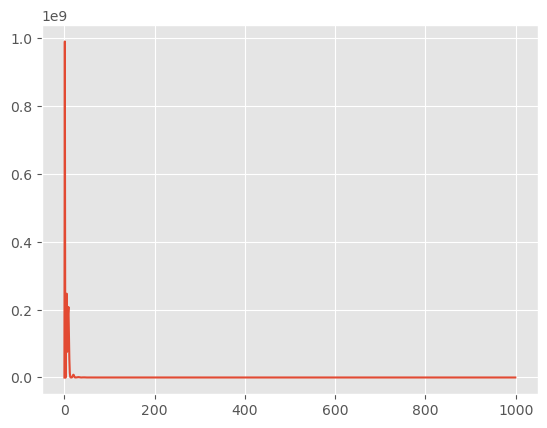

In [739]:
plt.plot(loss_saved)
#plt.yscale("log")

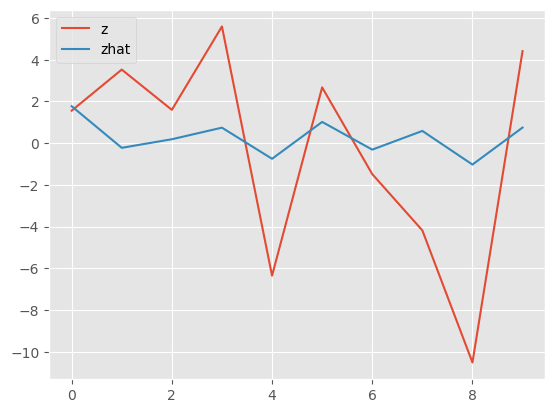

In [688]:
# Compare reconstructed zhat to original z
plt.plot(z, label="z")
zhat = model.nu_mean_z.cpu().data
plt.plot(zhat, label="zhat")
plt.legend(loc="best")

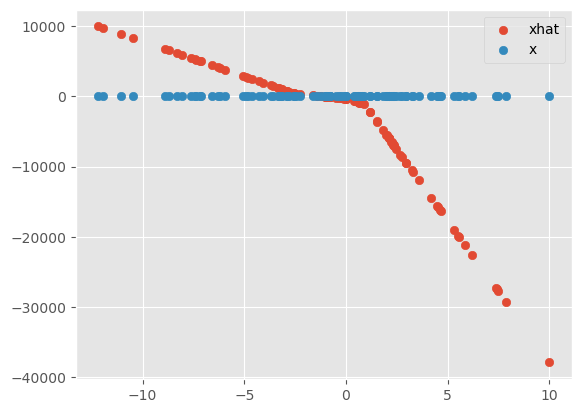

In [740]:
xhat = likelihood_NN(model.nu_mean_theta, z.to(device), model.z_dim, model.hidden_dim, model.x_dim)
xhat = xhat.cpu().detach().numpy()
xhat = xhat[:,0]

plt.scatter(x=z, y=xhat, label = "xhat")
plt.scatter(x=z, y=x.cpu(), label="x")
plt.legend(loc="best")

In [741]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.grad)

nu_mean_theta tensor([-0.0411, -0.0093,  0.0397,  0.0071, -0.0109, -0.0019,  0.0219,  0.0553,
         0.0000,  0.0000,  0.0339,  0.0077, -0.0063,  0.0017, -0.0018,  0.0000],
       device='cuda:0')
nu_sd_log_theta None
nu_mean_z None
nu_sd_z_log None
